Affinity Propagation Algorithm Implementation and Application
-----

**Authors: Zhangqi Chen, Yuwei Xu**

**Github link:https://github.com/zhangqichole/Yuwei-Zhangqi-AP**

1.Abstract
---
Affinity Propagation Algorithm is a single-exemplar based clustering algorithm. It creates clusters by sending messages between data points until convergence. Compared with other conventional clustering algorithms, Affinity Propagation Algorithm is efficient, simple and flexible. it can be applied in many areas such as business simulation, face recognition and computer vision.


In this project, we first introduce the background, characteristics and applications of this algorithm. Then we implement the algorithm and use vectorization and JIT to optimize it. To test its efficiency and accuracy, we apply this algorithm on two sets of simulated data and two sets of real data. Finally, we compare its performance with another two clustering algorithms, Kmeans and MeanShift.

2.Background
-----
The Affinity Propagation Algorithm was first proposed by Brendan Frey and Delbert Dueck in a paper named "Clustering by Passing Messages Between Data Points" in 2007. This algorithm is a clustering method that can be used to address unsupervised clustering problems.

- Applications

The Affinity Propagation Algorithm can be applied in various fields such as bioinformatics,computer vision, face recognition, genes detection and manuscript identification.

- Advantages 

Compared with other clustering algorithms(eg. k-means), the Affinity Propagation method has several advantages:

1. No need to set the number of clusters in advance.

2. Examplars are actual data points instead of the averages of data points(centroids in k-means algorithm).

3. Faster than other clustering algorithms in small data sets.

4. Not sensitive to initial values. No matter what initial values are, the final results will be the same.

5. Can be applied to general similarity data even asymmetric similiarity measures.


- Disadvantages

Although the Affinity Propagation Algorithm has many advantages, it also has some drawbacks:

1. Need to specify the preferences in advance, which may affact final results.

2. For large data sets, the algorithm often converges to suboptimal solutions.

3. The algorithm is complex with $O(N*N*logN)$. When it applied to large data sets, it tends to be very slow.


- Use in research

Affinity Propagation Clustering is especially powerful on high-dimensional and muti-class data sets. Therefore, it is can be applied in computer vision and image categorization.

In this project, we apply this clustering method on Olivetti face dataset to classify the face images and use it on breast cancer data.

**3.Description of algorithm**
----
The main idea of this affinity propagation algorithm is to take all the data points as the potential 'exemplars', calculate the messages exchanged between each data pairs and, through updating messages, find the most suitable exemplars. 

**Similarity $s(i,k)$**

$s(i,k) = -\parallel x_{i} - x_{k} \parallel ^2$ suggests the similarity between two data points which is shown as the negative Euclidean distance between two data points. If $s(i,k) > s(i,j)$ , it implies that data point i is more similar to data point k than j.

**Preference $s(k,k)$**

The diagonal values $s(k,k)$ are referred to as preferences. The larger the value of $s(k,k)$ is, the more likely that k can be chosen as an exemplar. Initially, all the data points are equally viewed as potential exemplars so the preferences are set to be a common value, usually the median value of the input similarities.

**Responsibility Matrix R**

R contains responsibility values $r(i,k)$. 

Responsibility is shown as
$r(i,k) \leftarrow s(i,k)-max_{k^{'}\neq k} \{a(i,k^{'}) + s(i,k^{'})\}$ which quantifies the suitability that $x_{k}$ is to be the exemplar for $x_{i}$ than other candidate exemplars. $r(i,k)$ is the message sent from data point i to potential exemplar k.

**Availability Matrix A**

A contains availability value $a(i,k)$ which is shown as $a(i,k) \leftarrow min\{0,r(k,k) + \sum_{i^{'} s.t.i^{'}\notin\{i,k\}}max\{0,r(i^{'},k)\}\}$. 

$a(i,k)$ is the message sent from potential exemplar k to data point i which evaluates how appropriate for data point i to choose k as its exemplar, considering the responsibility of k to other data points.

**Iteration Process**

Initially, matrix A and R are set all zeros. 

In the first iteration: $a(i,k)\leftarrow 0$ , $r(i,k) \leftarrow s(i,k)-max_{k^{'}\neq k} \{ s(i,k^{'})\}$ .

In the later iterations:

$a(i,k) \leftarrow min\{0,r(k,k) + \sum_{i^{'} s.t.i^{'}\notin\{i,k\}}max\{0,r(i^{'},k)\}\}$,

$a(k,k)\leftarrow \sum_{i^{'} s.t.i^{'}\notin\{i,k\}}max\{0,r(i^{'},k)\}\}$

$r(i,k) \leftarrow s(i,k)-max_{k^{'}\neq k} \{a(i,k^{'}) + s(i,k^{'})\}$

Within the maximize number of iterations, this process continues until the changes in the messages fall below a certain threshold or the local decisions stay unchanged after several iterations.

For each data point i, the data point k that maximizes the value $a(i,k)+r(i,k)$ is considered the most suitable exemplar.

**Damping Factor $\lambda$**

In order to reduce the numerical oscillations, each message is set to $\lambda$ times its previous iteration value plus $1-\lambda$ times its updated value.

The damping factor $\lambda$ is between 0 to 1, usually $\lambda=0.5$.

4.Implementation and Optimization 
---

We have managed to implement the affinity propagation clustering method and put them in a package called 'APClustering', which has been submitted to Source code.

In [1]:
!pip install .

Processing /Users/chenzhangqi/Desktop/APClustering
  Running setup.py bdist_wheel for APClustering ... done
  Stored in directory: /private/var/folders/l7/p1_0ltx504s58yxdg3ycv4j00000gn/T/pip-ephem-wheel-cache-mwt8k29a/wheels/c2/cf/92/f21a62628caaf52f6a8d47992d6251165f3bdaac9760044180
Successfully built APClustering
  Found existing installation: APClustering 1.0
    Uninstalling APClustering-1.0:
      Successfully uninstalled APClustering-1.0


In [66]:
import APClustering as apc
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.datasets.samples_generator import make_blobs
import warnings
from sklearn.cluster import KMeans, MeanShift,Birch
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import AffinityPropagation

**4.1 Using profiling to identify bottlenecks**

In [61]:
import numpy as np

def distance(a, b):
    """Compute the distance"""
    return np.linalg.norm(a - b)

def dist_matrix(a, b):
    """Return distance matrix"""
    c = (a - b).flatten()
    return np.linalg.norm(c)

def get_similarity_matrix(v):
    """Return the initial similarity matrix"""
    n = v.shape[0]
    s = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            s[i, j] = -distance(v[i], v[j])
    return s

def set_diag(m, v):
    """Set the values on the diagonal """
    for i in range(m.shape[0]):
        m[i, i] = v[i]
        
def get_coords(dimension, vs):
    """Get coordinates"""
    coordinates = []
    for v in vs:
        coordinates.append(v[dimension])
    return coordinates

def cluster_given_similarity_matrix(s, max_iter, conv_iter, damping, conv_threshold, pref, mode_term, lim_exemp):
    """''
    Identifies clusters and examplars
    
    Parameters:
    -----------
    s: similarity matrix
    conv_threshold: tolerance
    pref: preference
    max_iter: max iterations
    '''"""
    n = s.shape[0]

    if pref == 'default':
        set_diag(s, np.median(s) * np.ones(n))
    else:
        set_diag(s, pref)
    
    a = np.zeros((n, n))
    r = np.zeros((n, n))
    indices = np.arange(n)
    
    d = np.zeros((n, n))
    d_old = np.zeros((n, n))
    dist = -np.inf
    dist_old = np.inf
    distances = []
    n_it = 0
    sign_ex = np.zeros(1)
    sign_ex_old = np.zeros(1)
    n_stab_it = 0
    clusters = []
    clusters_old = []
    
    # alternating massage passing
    for it in range(max_iter):
        
        # records the number of iterations
        n_it += 1
        
        # updates responsibility matrix
        aux = np.add(a, s)
        largest_elems = np.max(aux, axis = 0)
        largest_elems_ind = np.argmax(aux, axis = 0)
        aux[indices, largest_elems_ind] = -np.inf
        second_largest_elems = np.max(aux, axis = 0)
        aux = np.tile(largest_elems, (n, 1)).T
        aux[indices, largest_elems_ind] = second_largest_elems
        r = (r + s - aux) * damping

        # updates availability matrix
        aux = np.maximum(r, 0)
        set_diag(aux, np.diag(r))
        aux -= np.sum(aux, axis = 1)
        temp = np.diag(aux).copy()
        aux = np.maximum(aux, 0)
        set_diag(aux, temp)
        a = (a - aux) * damping
        
        # identifies exemplars and clusters
        sign_ex_old = sign_ex
        clusters_old = clusters
        sign_ex = np.sign((np.diag(a) + np.diag(r)) - lim_exemp)
        ind_ex = indices[sign_ex > 0]
        clusters = []
        if len(ind_ex) > 0:
            det = np.add(a, r)
            k = 0
            for i in indices:
                if i not in ind_ex:
                    clusters.append([0, np.argmax(det[i, ind_ex])])
                else:
                    clusters.append([1, k])
                    k += 1
        
        #breaks from iteration if converged
        if mode_term == 'clusters':
            if clusters_old == clusters and len(clusters) > 0:
                n_stab_it += 1
            if n_stab_it == conv_iter:
                break
        elif mode_term == 'matrices':
            d_old = d
            d = np.add(a, r)
            distances.append(dist_matrix(d_old, d))
            if len(distances) >= conv_iter:
                to_break = True
                for i in range(conv_iter):
                    if abs(distances[len(distances) - i - 1]) > conv_threshold:
                        to_break = False
                if to_break:
                    break
            
    return clusters, len(ind_ex), n_it

# the default pref is the median of all similarities
# the default mode of termination is termination after stabilization of clusters
# an alternative mode of termination is termination after stabilization of
# the availability and responsibility matrices
def cluster(data, max_iter = 200, conv_iter = 20, damping = 0.5, conv_threshold = 1e-3, pref = 'default', mode_term = 'clusters', lim_exemp = 1e-3):
    """Return a collection of clusters, exemplars, iteration numbers and labels"""
    clusters = []
    centers = []
    labels = []
    
    s = get_similarity_matrix(data)
    results = cluster_given_similarity_matrix(s, max_iter, conv_iter, damping, conv_threshold, pref, mode_term, lim_exemp)
    n_clusters = results[1]

    for i in range(n_clusters):
        sublist = []
        clusters.append(sublist)

    i = 0
    for item in results[0]:
        labels.append(item[1])
        clusters[item[1]].append(data[i])
        if item[0] == 1:
            centers.append(data[i])
        i += 1
    
    return clusters, centers, results[2], labels

In [15]:
import profile
import math

In [16]:
points = np.vstack(np.random.randn(200, 2))
diag = np.ones(200) * -0.9

In [17]:
if __name__ == "__main__":
    profile.run("cluster(points, 200, 1e-3, diag)")

         395482 function calls in 6.278 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      200    0.002    0.000    0.003    0.000 :0(all)
    20801    0.151    0.000    0.151    0.000 :0(append)
        1    0.000    0.000    0.000    0.000 :0(arange)
      200    0.037    0.000    0.037    0.000 :0(argmax)
    41804    0.178    0.000    0.178    0.000 :0(array)
      200    0.003    0.000    0.003    0.000 :0(copy)
        1    0.000    0.000    0.000    0.000 :0(copyto)
      800    0.006    0.000    0.006    0.000 :0(diagonal)
    40000    0.488    0.000    0.488    0.000 :0(dot)
        1    0.000    0.000    0.000    0.000 :0(empty)
        1    0.000    0.000    6.278    6.278 :0(exec)
        1    0.000    0.000    0.000    0.000 :0(flatten)
        1    0.000    0.000    0.000    0.000 :0(get)
      200    0.001    0.000    0.001    0.000 :0(getattr)
        1    0.000    0.000    0.000    0.000 :0(hasattr)
    

From the results, we can know that the 'get_similarity_matrix' function is the most time-consuming. If the speed of this function can be increased, the efficiency of 'cluster' function can also be improved. Then we plan to use some methods to speed up the 'get_similarity_matrix' function .

**4.2 Optimization with vectorization**

In [18]:
def get_similarity_matrix_vec(v):
    n = v.shape[0]
    s = np.zeros((n, n))
    one = np.ones([n,1])
    for i in range(n):
        s[:,i] = -np.linalg.norm(v - (one @np.expand_dims(v[i,:] , axis=0)), axis=1)
    return s

In [24]:
def cluster_vec(data, max_iter = 200, conv_iter = 20, damping = 0.5, conv_threshold = 1e-3, pref = 'default', mode_term = 'clusters', lim_exemp = 1e-3):
    
    clusters = []
    centers = []
    labels = []
    
    s = get_similarity_matrix_vec(data)
    results = cluster_given_similarity_matrix(s, max_iter, conv_iter, damping, conv_threshold, pref, mode_term, lim_exemp)
    n_clusters = results[1]

    for i in range(n_clusters):
        sublist = []
        clusters.append(sublist)

    i = 0
    for item in results[0]:
        labels.append(item[1])
        clusters[item[1]].append(data[i])
        if item[0] == 1:
            centers.append(data[i])
        i += 1
    
    return clusters, centers, results[2], labels

In [22]:
%timeit cluster(points, 200, 1e-3, diag)

649 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit cluster_vec(points, 200, 1e-3, diag)

417 ms ± 65.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**4.3 Optimization with JIT**

In [26]:
import numba as nb

@nb.jit(parallel=True)
def get_similarity_matrix_jit(v):
    n = v.shape[0]
    s = np.zeros((n, n))
    one = np.ones([n,1])
    for i in range(n):
        s[:,i] = -np.linalg.norm(v - (one @np.expand_dims(v[i,:] , axis=0)), axis=1)
    return s

In [29]:
@nb.jit()
def cluster_jit(data, max_iter = 200, conv_iter = 20, damping = 0.5, conv_threshold = 1e-3, pref = 'default', mode_term = 'clusters', lim_exemp = 1e-3):
    
    clusters = []
    centers = []
    labels = []
    
    s = get_similarity_matrix_jit(data)
    results = cluster_given_similarity_matrix(s, max_iter, conv_iter, damping, conv_threshold, pref, mode_term, lim_exemp)
    n_clusters = results[1]

    for i in range(n_clusters):
        sublist = []
        clusters.append(sublist)

    i = 0
    for item in results[0]:
        labels.append(item[1])
        clusters[item[1]].append(data[i])
        if item[0] == 1:
            centers.append(data[i])
        i += 1
    
    return clusters, centers, results[2], labels

In [30]:
%timeit cluster_jit(points, 200, 1e-3, diag)

380 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


5.Test/Application on Simulated Data and Real Data
---

**5.1 Test with simulated data**
--

**Simulated Data - 1**

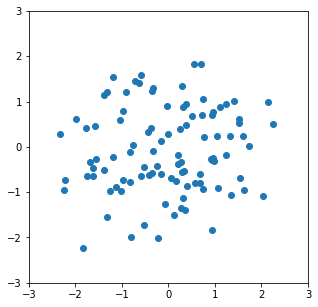

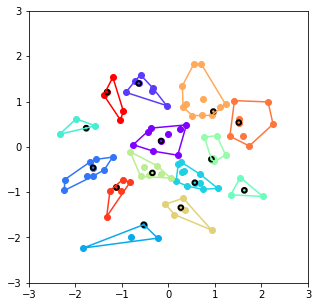

In [31]:
points = np.vstack(np.random.randn(100, 2))
plt.figure(figsize=(5,5))
plt.scatter(points[:, 0], points[:, 1])
axes = plt.gca()
axes.set_xlim([-3, 3])
axes.set_ylim([-3, 3])

results = apc.cluster(points, pref = np.ones(100) * -0.9)

clusters = results[0]
examplars = results[1]
n_clusters = len(examplars)
    
xs = []
ys = []
for i in range(n_clusters):
    x = []
    y = []
    for p in clusters[i]:
        x.append(p[0])
        y.append(p[1])
    xs.append(x)
    ys.append(y)

vs = []
for c in clusters:
    if len(c) > 2:
        vs.append(ConvexHull(c).vertices)
    else:
        vs.append(range(len(c)))

bs_x = []
bs_y = []

for i in range(n_clusters):
    b_x = []
    b_y = []
    for n in vs[i]:
        b_x.append(clusters[i][n][0])
        b_y.append(clusters[i][n][1])
    b_x.append(b_x[0])
    b_y.append(b_y[0])
    bs_x.append(b_x)
    bs_y.append(b_y)
        
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
plt.figure(figsize=(5, 5))
f = plt.gca()
f.set_xlim([-3, 3])
f.set_ylim([-3, 3])
for i in range(n_clusters):
    plt.scatter(xs[i], ys[i], color = colors[i])
    f.add_artist(plt.Circle(examplars[i], 0.05, fill = False, lw = 2, color = 'black'))
    plt.plot(bs_x[i], bs_y[i], color = colors[i])

**Simulated Data - 2（Small data set)**

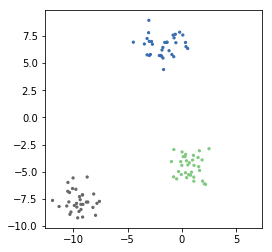

In [42]:
np.random.seed(100)
npts = 100
nc = 3
X, y = make_blobs(n_samples=npts, centers=nc)
plt.scatter(X[:, 0], X[:, 1], s=5, c=y,
            cmap=plt.cm.get_cmap('Accent', nc))
plt.axis('square')
pass

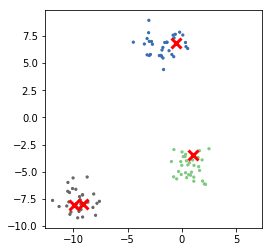

In [47]:
results = apc.cluster(X, mode_term = 'matrices', lim_exemp = 1.0, pref = np.ones(100) * -3.3)
centers = results[1]

center_xs = apc.get_coords(0, centers)
center_ys = apc.get_coords(1, centers)

plt.scatter(X[:, 0], X[:, 1],s=5, c=y, cmap=plt.cm.get_cmap('Accent', nc))
plt.scatter(center_xs, center_ys, marker = 'x', linewidth = 3, s = 100, c = 'red')
plt.axis('square')
pass

**Simulated Data - 3(large data set)**

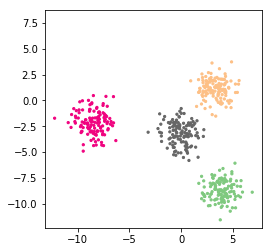

In [48]:
np.random.seed(500)
npts1 = 500
nc1 = 4
X1, y1 = make_blobs(n_samples=npts1, centers=nc1)
plt.scatter(X1[:, 0], X1[:, 1], s=5, c=y1,
            cmap=plt.cm.get_cmap('Accent', nc1))
plt.axis('square')
pass

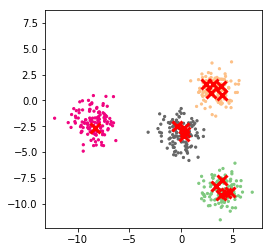

In [38]:
results_1 = apc.cluster(X1, mode_term = 'clusters', lim_exemp = 0.405, pref = np.ones(500) * -1.493)
centers_1 = results_1[1]

center_xs_1 = apc.get_coords(0, centers_1)
center_ys_1 = apc.get_coords(1, centers_1)

plt.scatter(X1[:, 0], X1[:, 1],s=5, c=y1, cmap=plt.cm.get_cmap('Accent', nc1))
plt.scatter(center_xs_1, center_ys_1, marker='x', linewidth=3, s=100, c='red')
plt.axis('square')
pass

**5.2 Examples**
---

**5.21 Real Data - breast_cancer**

In [62]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

bc = load_breast_cancer(return_X_y = True)
data = bc[0]
labels_t = bc[1]

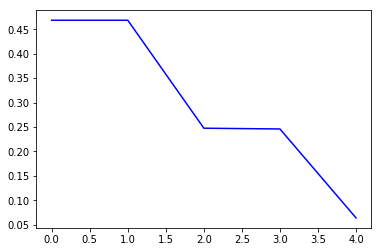

In [63]:
warnings.simplefilter('ignore')
accuracy = []
n = 5
for i in range(n):
    results = apc.cluster(data, mode_term = 'matrices', lim_exemp = 100 - i*19, pref = np.ones(len(data)) * (-74))
    labels = np.array(results[3])
    accuracy.append(metrics.adjusted_rand_score(labels_t, labels))
    
plt.plot(np.arange(n), accuracy, 'k', color = 'blue')
pass

**5.211 Comparing our results with another two clustering methods**

In [64]:
results = apc.cluster(data, mode_term = 'matrices', lim_exemp = 100, pref = np.ones(len(data)) * -74)
labels = np.array(results[3])
print("Affinity Propagation Rand Index: {}".format(metrics.adjusted_rand_score(labels_t, labels)))

kmeans = KMeans().fit(data)
labels_kmeans = kmeans.labels_
print("Kmeans Rand Index: {}".format(metrics.adjusted_rand_score(labels_t, labels_kmeans)))

Affinity Propagation Rand Index: 0.4683200215385412
Kmeans Rand Index: 0.23417751663312886


In [67]:
birch = Birch().fit(data)
labels_birch = birch.labels_
print("Birch Rand Index: {}".format(metrics.adjusted_rand_score(labels_t, labels_birch)))

Birch Rand Index: 0.39028769850145


**5.22 Real Data - fetch_olivetti_faces**

In [53]:
from sklearn.datasets import fetch_olivetti_faces 
of = fetch_olivetti_faces()
data = of.data

In [54]:
# this is the algorithm we developed
# this section generates the labels for the 400 images respectively, representing the clusters they belong to
warnings.simplefilter('ignore')
results = apc.cluster(data, mode_term = 'matrices', pref = np.ones(400) * -10)
labels_1 = np.array(results[3])

**5.221 Comparing our results with existing package**

In [55]:
# this is the algorithm included in sklearn.cluster
# the following parameters result in relatively high accuracy, compared to other combinations
ap = AffinityPropagation(convergence_iter = 20, damping = 0.9, max_iter = 1000).fit(data)
labels_2 = ap.labels_

In [68]:
# true labels
labels_t = np.empty(400)
for i in range(400):
    labels_t[i] = int(i / 10)

In [57]:
print("Affinity Propagation Rand Index 1: {}".format(metrics.adjusted_rand_score(labels_t, labels_1)))
print("Affinity Propagation Rand Index 2: {}".format(metrics.adjusted_rand_score(labels_t, labels_2)))

Affinity Propagation Rand Index 1: 0.45395515869164316
Affinity Propagation Rand Index 2: 0.4852536013224529


**5.222 Comparing our results with another two clustering methods**

In [96]:
# for unknown reasons the accuracy of these two methods are exceptionally low
kmeans = KMeans().fit(data)
labels_kmeans = kmeans.labels_
print("Kmeans Rand Index: {}".format(metrics.adjusted_rand_score(labels_t, labels_kmeans)))

meanshift = MeanShift().fit(data)
labels_meanshift = meanshift.labels_
print("Meanshift Rand Index: {}".format(metrics.adjusted_rand_score(labels_t, labels_meanshift)))

Kmeans Rand Index: 0.12390133690553883
Meanshift Rand Index: 0.0


**5.23 Adjusting parameters**

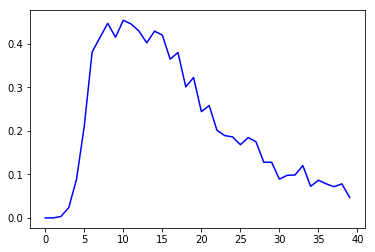

In [98]:
# when other factors are fixed, adjusting the value of shared preference would result in the following
warnings.simplefilter('ignore')
accuracy = []
n = 40
for i in range(n):
    results = apc.cluster(data, pref = np.ones(400) * -i)
    labels_1 = np.array(results[3])
    accuracy.append(metrics.adjusted_rand_score(labels_t, labels_1))
    
plt.plot(np.arange(n), accuracy, 'k', color = 'blue')
pass

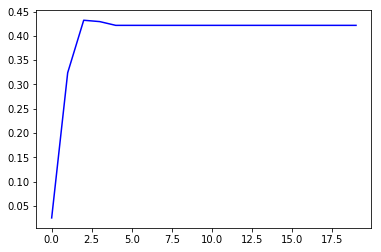

In [104]:
# adjusting convergence condition alone would result in the following
warnings.simplefilter('ignore')
accuracy = []
n = 20
for i in range(n):
    results = apc.cluster(data, lim_exemp = 10**-i, pref = np.ones(400) * -10)
    labels_1 = np.array(results[3])
    accuracy.append(metrics.adjusted_rand_score(labels_t, labels_1))
    
plt.plot(np.arange(n), accuracy, 'k', color = 'blue')
pass

6.Comparative analysis with competing algorithms
------

In [73]:
centers = [[1, 1], [-1, -1], [1, -1]]
X2, label_true = make_blobs(n_samples=100, centers=centers, cluster_std=0.5, random_state=2019)

In [74]:
results = apc.cluster(X2, pref = np.ones(100) * -0.8)
label_ap = results[3]
#print(label_ap)
print("Affinity Propagation Rand Index: {}".format(metrics.adjusted_rand_score(label_true, label_ap)))

kmeans = KMeans().fit(X2)
label_kmeans = kmeans.labels_
print("Kmeans Rand Index: {}".format(metrics.adjusted_rand_score(label_true, label_kmeans)))

meanshift = MeanShift().fit(X2)
label_meanshift = meanshift.labels_
print("Meanshift Rand Index: {}".format(metrics.adjusted_rand_score(label_true, label_meanshift)))
print("Affinity Propagation has the highest accuracy compared with Kmeans and Meanshift.")

Affinity Propagation Rand Index: 0.5222527337467606
Kmeans Rand Index: 0.43257991347387187
Meanshift Rand Index: 0.4484609279246689
Affinity Propagation has the highest accuracy compared with Kmeans and Meanshift.


7.Conclusion
-----

In this project, we implement the affinity propagation method and optimize it by using vectorization and JIT. Based on the implementation, we test the method on three sets of simulated data and two sets of real data. Moreover, we compare its accuracy and effeciency  with an existing package and two competing algorithms.

From comparing with Kmeans and Meanshift method, we find that affinity propagation method is more accurate and efficient in small data sets. Moreover, it performs well in high-dimensional data sets.

From testing on simulated large data sets, we find that this method cannot converge to optimal solutions, which means the affinity propagation method has relatively low accuracy when it comes to large data sets. Also, we notice that when there is no prior knowledge of metric (distance function for the similarity matrix), this method is hard to achieve optimal results. One possible improvement is to use weighted euclidean distances instead of basic euclidean distances as the similarity matrix. To obtain optimal weights, we can use gradient descent method in training data sets. However, if the matric are especially complex, this limitation is hard to improve.

8.Reference
---

[1] Brendan J. Frey and Delbert Dueck. "Clustering by Passing Messages Between Data Points". Science Feb. 2007

[2] Delbert Dueck. "Affinity Propagation: Clustering Data by Passing Messages". University of Toronto. 2009